#### 什么是异常检测？noise outlier

异常一般指的是与标准值（或期待值）有偏离的样本，跟绝大部分数据“长得不一样”。

### 特点：

- 异常不一定是“坏”事情，往往是“有价值”的事情，我们对异常的成因感兴趣
- 异常检测往往在**无监督**的模式下完成的—-历史数据中没有标签，我们不知道哪些数据是异常。无法用监督学习去检测

### 异常检测的应用：

- 金融行业的反欺诈、信用卡欺诈检测：把欺诈或者金融风险当做异常
- 罕见病检测：把罕见病当作异常，比如检测早发生的阿兹海默症
- 入侵检测：把网络流量中的入侵当做异常
- 机器故障检测：实时监测发现或预测机械故障
- 图结构、群体检测：比如检测疫情的爆发点等

### 异常检测的挑战与难点：

1. 大部分情况是无监督学习，没有标签信息可以使用
2. 数据极端不平衡（异常点仅占总体数据的一小部分），建模难度大
3. 检测方法往往涉及到密度估计，需要进行大量的距离/相似度计算，运算开销大
4. 在实际场景中往往需要实时检测，比离线检测的技术难度更高
5. 在实际场景中，常需要处理很多案例，运算开销大
6. 解释性比较差，很难给出异常检测的原因，尤其是在高维数据上，但业务方需要了解异常成因
7. 在实际检测中，往往有一些检测的历史规则，如何与学习模型进行整合

Python:

TODS(与PyOD类似，包含多种时间序列检测）

### 异常检测算法大致可以分为：

- 线性模型(linear model): PCA
- 基于相似度的度量的算法(Probability-based model): KNN, LOF,HBOS
- 基于概率的算法(Probabilistic Model): COPOD
- 集成检测算法(Ensemble Model):孤立森林（Isolation Forest), XGBOD
- 神经网络算法(Neural Networks):自编码器(AutoEncoder)

### 评估方法不能用简单的准确度(accuracy):因为数据的极端不平衡 ：

- ROC-AUC曲线
- Precision @RANK k:  top k精确度
- Average Precision:平均精确度

## 异常检测方法1：KNN

In [7]:
from pyod.models.knn import KNN

In [3]:
from pyod.utils.data import generate_data #test generation
from pyod.utils.data import evaluate_print #evaluate the result
from pyod.utils.example import visualize # draw the result

D:\ProgramData\Anaconda3\lib\site-packages\pyod\utils\data.py:189: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)



On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0


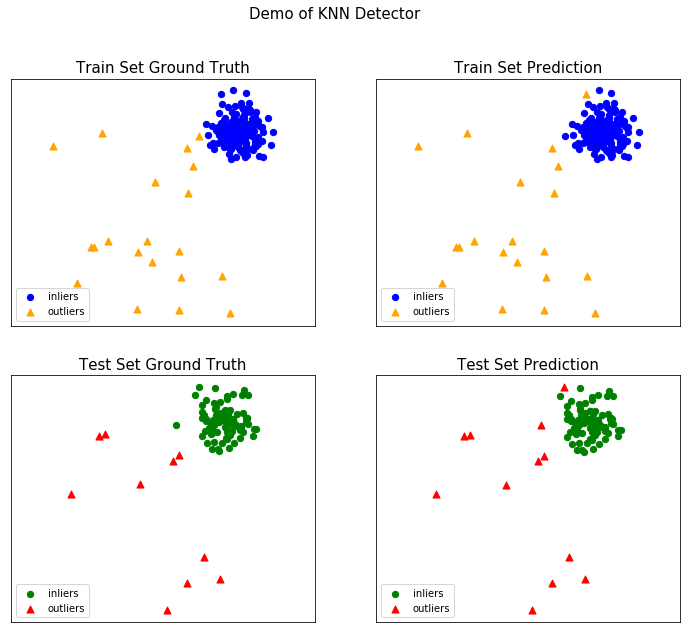

In [5]:
if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)

    # train kNN detector
    clf_name = 'KNN'
    clf = KNN()
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)

    # visualize the results
    visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=True)

## 异常检测方法2：LOF
计算每个点在局部区域上的密度和其邻域点的密度来判断异常程度

In [6]:
from pyod.models.lof import LOF

## 异常检测方法3：HBOS
假设每个维度都是独立的，分别计算一个样本在不同维度上所处的密度空间，并叠加结果。H: histogram

#### 优点：简单、开销小，可并行计算，适用于大数据
#### 缺点：无法考虑不同特征之间的关系（dependency），虽然在实际使用中效果很好

In [9]:
from pyod.models.hbos import HBOS

## 异常检测方法4：COPOD
计算一个（多维）样本在每个维度上是异常点的可能性，再合并所有的维度上的结果
### 优点：运行快，无需调参，有一定的解释性（比如哪个特征更有解释性）
### 缺点：决策边界比较复杂

 传统的统计方法会把特征空间上的每个维度单独建模，然后估算一个样本在这个维度上的“异常程度”（比如是否在2个δ以外）但这种思想忽略了不同维度之间并不独立（特征点并非是完全独立的）。因此通过一个copula函数（一种概率模型），可以对所有特征一并联合建模估算出“经验累积分布函数”，并用它来估计每个样本在不同维度上有多么“异常”

## 异常检测方法5：孤立森林
决策过程是不断对特征空间进行划分，异常点一般处于树的上面（离root更近）

利用决策树的特点，多次对特征空间进行划分，然后观察“孤立”一个点的难易程度。异常点往往在比较密集的地方，更容易被隔离出来（决策树的深度比较低）
### 优点：运行快，效果好，适用于大量数据，容易并行
### 缺点：需要调的参数比较多，结果有一定的随机性

## 异常检测方法6： PCA
对全部数据计算特征向量，异常样本距离特征向量的距离比较远，因此这个距离可以被作为异常值
### 优点：直觉上简单，运算开销适中
### 缺点：作为一种线性模型，有一定局限性

## 异常检测方法7：自编码器
跟PCA类似，但扩展到了非线性 模型上。通过自编码器的先压缩（encoder）再还原(decoder)，异常点会有更大的重建误差（reconstruction error）
### 优点：理解简单，是PCA类模型的非线性扩展，数据量大，特征多时适用
### 缺点：神经网络模型往往有一定的随机性，运算开销比较大

## 异常检测方法8（supervised）:XGBOD
如果数据有标签，结合xgboost与无监督的检测方法（把无监督的方法当做增强特征空间的方法）
### 优点：可以同时利用数据中自带的标签，以及无监督学习带来的更好的表达
### 缺点：需要标签信息，运算开销比较大

## 异常检测中的一些技巧
#### 数据有标签优先使用监督学习
#### 如果不知道用什么模型，可以使用MetaOD进行自动模型选择。如果不知道该选什么模型，优先选择孤立森林
#### 手动选择模型的话，**首先要考虑数据量和数据结构**。数据量比较大(>10万，>100个特征），优先选择可扩展性强的算法，如孤立森林、HBOS和COPOD
#### 如果最终的结果需要一定的解释性，可以选择孤立森林或者COPOD
#### 如果数据量不大，追求精度比较高的结果，可以尝试随机训练多个检测模型，并使用LSCP来进行合并
#### 训练和预测过程慢，开销大的话，加速可以使用SUOD
#### **如果数据量大、特征多，可以尝试基于神经网络的方法**，并有GPU并行等方法